In [1]:
# pip install git+https://github.com/sign-language-processing/datasets.git -q

## Dataset download

In [1]:
import tensorflow_datasets as tfds
# import sign_language_datasets.datasets
from sign_language_datasets.utils.torch_dataset import TFDSTorchDataset
from sign_language_datasets.datasets.config import SignDatasetConfig

import itertools

/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-05 12:35:24.434236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 12:35:24.434264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 12:35:24.435411: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 12:35:24.441491: I tensorflow/core/platform/cpu_feature_guard.cc:182] This 

In [2]:
DATA_DIR = "/mnt/data3/tfds_slt"

In [3]:
config = SignDatasetConfig(name="rwth_phoenix2014_t_poses", version="3.0.0", include_video=False, include_pose="holistic")
rwth_phoenix2014_t = tfds.load(name='rwth_phoenix2014_t', builder_kwargs=dict(config=config), data_dir=DATA_DIR)

2024-03-05 12:35:28.947333: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 12:35:28.949559: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 12:35:28.949929: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
train_dataset = TFDSTorchDataset(rwth_phoenix2014_t["train"])
test_dataset = TFDSTorchDataset(rwth_phoenix2014_t["test"])

In [5]:
for datum in itertools.islice(train_dataset, 0, 5):
	print((datum.keys()))
	print(f"Pose shape: {datum['pose']['data'].shape}")
	print(f"Text: {datum['text'].decode('utf-8')}")
	print()

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([47, 1, 543, 3])
Text: guten abend liebe zuschauer

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([56, 1, 543, 3])
Text: im bergland fällt zunehmend schnee

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([70, 1, 543, 3])
Text: und der wind weht auch noch kräftig aus west bis nordwest

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([99, 1, 543, 3])
Text: die aussichten von montag bis mittwoch ändert sich das wetter kaum

dict_keys(['gloss', 'id', 'pose', 'signer', 'text'])
Pose shape: torch.Size([123, 1, 543, 3])
Text: über dem bergland können sich einzelne quellwolken zeigen in küstennähe gibt es auch mal dichtere wolken



## Dataset analysis

In [6]:
src_lenghts = []
texts = []

for datum in rwth_phoenix2014_t["train"]:
	src_lenghts.append(datum['pose']['data'].shape[0])
	texts.append(datum['text'].numpy().decode('utf-8'))

### Frames analysis for padding and truncation

In [8]:
import pandas as pd


src_lengths_df = pd.Series(src_lenghts)
src_lengths_df.describe(percentiles=[.75, .9, .95, .99])

count    7096.000000
mean      116.594419
std        49.859426
min        16.000000
50%       112.000000
75%       144.000000
90%       182.000000
95%       208.000000
99%       259.000000
max       475.000000
dtype: float64

<Axes: >

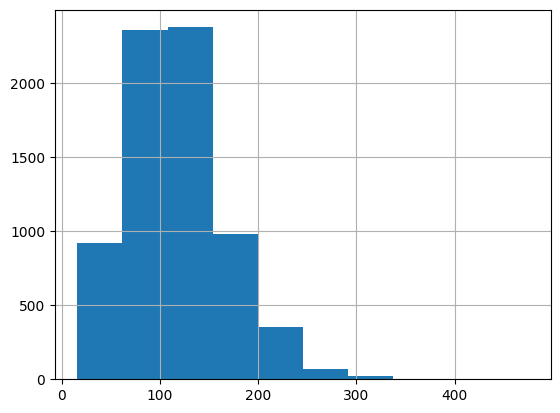

In [9]:
src_lengths_df.hist()

### Text tokenization and analysis for padding and truncation

In [10]:
from transformers import AutoTokenizer


TEXT_MODEL = "google-bert/bert-base-german-cased"
tokenizer = AutoTokenizer.from_pretrained(TEXT_MODEL)

In [11]:
tokenized_sequences = tokenizer(texts, padding=True)

In [12]:
tokens_length = [len(tokens) for tokens in tokenized_sequences['input_ids']]
print(max(tokens_length))

69


In [13]:
print(texts[1])
print(tokenized_sequences[1].ids)

im bergland fällt zunehmend schnee
[3, 106, 25714, 374, 5483, 7231, 9599, 26897, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Preprocessing and dataloader generation

In [16]:
import torch
from torch import Tensor
import torch.utils.data as utils


MAX_FRAMES = 259
MAX_TOKENS = 150

def flatten_keypoints(datum: Tensor):
	'''
		Reshape the pose of datum only keeping the first dimension S (sequence lenght) and flattening the number of keypoints K and their dimensions D.
		Args:
			datum: Tensor of shape (S, D, K)
		Returns:
			Tensor of shape (frames, D * K)
	'''
	return datum.view(datum.size(0), -1)

def pad_truncate_src(datum: Tensor, max_len: int):
	'''Pad the pose to max_len or truncate it'''
	if datum.size(0) < max_len:
		return torch.cat([datum, torch.zeros(max_len - datum.size(0), datum.size(1))])
	else:
		return datum[:max_len]

def collate_fn(batch):
	src = [item['pose']['data'] for item in batch]
	src = torch.stack([pad_truncate_src(flatten_keypoints(datum), MAX_FRAMES) for datum in src])
	tgt = [str(item['text']) for item in batch]
	tgt = tokenizer(tgt, padding='max_length', max_length=MAX_TOKENS, return_tensors='pt').input_ids
	return src, tgt

train_loader = utils.DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn)

In [17]:
for src, tgt in train_loader:
  print(src.shape)
  print(tgt.shape)
  break

torch.Size([4, 259, 1629])
torch.Size([4, 150])


## Model

### Model definition

In [17]:
# !pip install lightning -q

In [19]:
import torch


def generate_square_subsequent_mask(sz: Tensor, device: torch.device):
    '''
        Generates triangular (size, size) mask for the transformer model.
    '''
    mask = (torch.triu(torch.ones((sz, sz))) == 1).transpose(0, 1).to(device)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_target_mask(tgt: Tensor, pad_idx: int, device: torch.device):
    '''
        Create target mask for the transformer model.
        Args:
            tgt: (N, T) where N is the batch size and T is the target sequence length
            pad_idx: padding index
            device: torch device
        Returns
            tgt_mask: (T, T), so to evaluate the i-th token, we can only look at the first i tokens, for all i's
            tgt_padding_mask: (N, T), for masking pad tokens
    '''
    tgt_seq_len = tgt.shape[1]
    tgt_mask = generate_square_subsequent_mask(tgt_seq_len, device)
    tgt_padding_mask = (tgt == pad_idx)
    return tgt_mask, tgt_padding_mask

In [24]:
from torch import Tensor, nn
from torch.nn.functional import relu


class KeypointsEmbedding(nn.Module):

    def __init__(self,
                in_features: int,
                keys_emb_size: int = 128,
                kernel_size: int = 5,
                out_channels: int = 64,
                ):
        super(KeypointsEmbedding, self).__init__()

        self.fc = nn.Linear(in_features=in_features, out_features=keys_emb_size)
        self.conv1d = nn.Conv1d(in_channels=keys_emb_size, out_channels=out_channels, kernel_size=kernel_size)

    def forward(self, src_batch: Tensor):
        '''
            Args:
                src_batch: (N, S, E)
            Returns:
                Embedding tensor of shape (N, S - kernel_size + 1, out_channels)
        '''
        # flatten and apply fc frame by frame, then stack the frames and permute dims for conv; this for each sample in batch
        n,s,e = src_batch.shape
        src_batch = src_batch.view(n*s,-1)
        src_emb = relu(self.fc(src_batch)).view(n,s,-1)
        # src_emb = stack([stack([relu(self.fc(frame)) for frame in sample]) for sample in src_batch])
        src_emb = src_emb.permute(0, 2, 1)
        src_emb = self.conv1d(src_emb).permute(0, 2, 1)
        return src_emb

In [21]:
import math

import torch
from torch import nn, Tensor


class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [22]:
import math
from torch import nn, Tensor


class TokenEmbedding(nn.Module):
    '''Code taken from https://pytorch.org/tutorials/beginner/translation_transformer.html'''

    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

In [22]:
# from transformers import AutoModel

# bert_german = AutoModel.from_pretrained(TEXT_MODEL)

In [28]:
from torch import Tensor, nn


class KeypointModel(nn.Module):
    # S is the source sequence length, T is the target sequence length, N is the batch size, E is the feature number

    def __init__(self,
                src_max_len: int,
                tgt_max_len: int,
                in_features: int,
                tgt_vocab_size: int,
                d_model: int = 64,
                kernel_size: int = 5,
                keys_initial_emb_size: int = 128,
                ):
        super(KeypointModel, self).__init__()

        # in_features is the result of flattening the input of (x,y,c).(k1, ..., k42)
        self.keys_emb = KeypointsEmbedding(in_features=in_features, keys_emb_size=keys_initial_emb_size, kernel_size=kernel_size, out_channels=d_model)
        self.src_pe = PositionalEncoding(d_model=d_model, max_len=src_max_len - kernel_size + 1)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, d_model)
        self.tgt_pe = PositionalEncoding(d_model=d_model, max_len=tgt_max_len)
        self.transformer = nn.Transformer(d_model=d_model, batch_first=True)
        self.generator = nn.Linear(d_model, tgt_vocab_size)


    def forward(self,
                src: Tensor, # (N, S, E)
                tgt: Tensor, # (N, S, E)
                tgt_mask: Tensor, # (T, T)
                tgt_padding_mask: Tensor # (N, T)
    ):
        print(src.shape)
        src_emb = self.keys_emb(src)
        src_emb = self.src_pe(src_emb)
        tgt_emb = self.tgt_pe(self.tgt_tok_emb(tgt))
        print(src_emb.shape, tgt_emb.shape, tgt_mask.shape, tgt_padding_mask.shape)
        outs = self.transformer(
            src = src_emb, 
            tgt = tgt_emb, 
            src_mask = None, 
            tgt_mask = tgt_mask, 
            src_key_padding_mask = None, 
            tgt_key_padding_mask = tgt_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        src_emb = self.src_pe(self.keys_emb(src).permute(2,0,1))
        return self.transformer.encoder(src_emb, src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.tgt_pe(self.tgt_tok_emb(tgt)), memory, tgt_mask)


# d_model tiene que ser par para que ande el pos encoding porque usa la mitad con seno y la mitad con coseno
model = KeypointModel(src_max_len=MAX_FRAMES, tgt_max_len=MAX_TOKENS, in_features=543*3, tgt_vocab_size=tokenizer.vocab_size)

In [29]:
from modelsummary import summary


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for src, tgt in train_loader:
    src = src.to(device)
    tgt = tgt.to(device)
    tgt_mask, tgt_padding_mask = create_target_mask(tgt, 0, device)
    print(src.shape, tgt.shape, tgt_mask.shape, tgt_padding_mask.shape)
    model = model.to(device)
    # logits = model(src, tgt, tgt_mask, tgt_padding_mask)
    summary(model, src, tgt, tgt_mask, tgt_padding_mask)
    break

torch.Size([4, 259, 1629]) torch.Size([4, 150]) torch.Size([150, 150]) torch.Size([4, 150])
torch.Size([4, 259, 1629])
torch.Size([4, 255, 64]) torch.Size([4, 150, 64]) torch.Size([150, 150]) torch.Size([4, 150])
-----------------------------------------------------------------------
             Layer (type)                Input Shape         Param #
     KeypointsEmbedding-1            [-1, 259, 1629]               0
                 Linear-2                 [-1, 1629]         208,640
                 Conv1d-3             [-1, 128, 259]          41,024
     PositionalEncoding-4              [-1, 255, 64]               0
                Dropout-5              [-1, 255, 64]               0
         TokenEmbedding-6                  [-1, 150]               0
              Embedding-7                  [-1, 150]       1,920,000
     PositionalEncoding-8              [-1, 150, 64]               0
                Dropout-9              [-1, 150, 64]               0
           Transformer-10

/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


## Model training

In [28]:
# !pip install wandb -q

In [ ]:
from torch import optim, nn, utils, Tensor
import lightning as L


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the LightningModule
class LitKeypointModel(L.LightningModule):

    def __init__(self, model: KeypointModel):
        super().__init__()
        self.keypoint_model = model
    
    def forward(self, src: Tensor, tgt: Tensor, tgt_mask: Tensor, tgt_padding_mask: Tensor):
        src = src
        tgt = tgt
        tgt_mask = tgt_mask
        tgt_padding_mask = tgt_padding_mask
        return self.keypoint_model(src, tgt, tgt_mask, tgt_padding_mask)

    def training_step(self, batch, batch_idx):
        src, tgt = batch
        tgt_mask, tgt_padding_mask = create_target_mask(tgt, 0, device)
        # src_mask is set to none as we use the whole input at every timestep and we have no padding
        logits = model(src, tgt, None, tgt_mask, None, tgt_padding_mask, None)

        loss = nn.functional.cross_entropy(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        src, tgt = batch

        tgt_mask, tgt_padding_mask = create_target_mask(tgt, 0, device)
        logits = model(src, tgt, None, tgt_mask, None, tgt_padding_mask)

        loss = nn.functional.cross_entropy(logits.reshape(-1, logits.shape[-1]), tgt.reshape(-1))

        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


lit_model = LitKeypointModel(model)

In [29]:
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="rwth_test")

In [30]:
# train the model (hint: here are some helpful Trainer arguments for rapid idea iteration)
trainer = L.Trainer(max_epochs=3, logger=wandb_logger, default_root_dir=".")
trainer.fit(model=lit_model, train_dataloaders=train_loader)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pedroodb (lidiaa). Use `wandb login --relogin` to force relogin


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type          | Params
-------------------------------------------------
0 | keypoint_model | KeypointModel | 7.6 M 
-------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.377    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type          | Params
-------------------------------------------------
0 | keypoint_model | KeypointModel | 7.6 M 
-------------------------------------------------
7.6 M     Trainable params
0         Non-trainable params
7.6 M     Total params
30.377    Total estimated model params size (MB)
/home/pdalbianco/anaconda3/envs/slt_datasets/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many wo

Epoch 0:   0%|          | 0/1774 [00:00<?, ?it/s] 

TypeError: KeypointModel.forward() takes 5 positional arguments but 8 were given